## ANALYSING TIME SERIES_ Temperature forecast
### The objective in this project is to build amodel to predict the temperature for the upcoming days given the temperature till today


In [76]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:

### Import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Time Series Analysis
import statsmodels.tsa.stattools as tsa 
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Modell and metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

In [80]:
# reading the initial textfile and making a dataframe
df = pd.read_table('/content/drive/MyDrive/07_Time Series Analysis _Temperature forecast/TG_STAID002759.txt', skiprows=19, sep= ',')
df.columns = ['source_identifier', 'date', 'average_temp', 'quality'] 

df.head(10)

,source_identifier,date,average_temp,quality
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
5,127488,18760106,-77,0
6,127488,18760107,-66,0
7,127488,18760108,-89,0
8,127488,18760109,-127,0
9,127488,18760110,-89,0


In [81]:
df.shape

(53357, 4)

In [82]:
# cleaning up the data a little
# lets drop source identifier because it wont help us for prediciting
df = df.drop('source_identifier', axis=1)
df

,date,average_temp,quality
0,18760101,22,0
1,18760102,25,0
2,18760103,3,0
3,18760104,-58,0
4,18760105,-98,0
...,...,...,...
53352,20220127,44,0
53353,20220128,49,0
53354,20220129,58,0
53355,20220130,58,0


In [83]:
df['quality'].value_counts()

0    53161
9      195
1        1
Name: quality, dtype: int64

In [84]:
# all the temperature values corespondent to 195 in 'quality' are -9999 so they have to be removed
# i will transfer them to NaN and then remove them
df['average_temp'].replace(-9999, np.NaN, inplace =True)

In [85]:
df.isnull().sum()

date              0
average_temp    195
quality           0
dtype: int64

In [86]:
df.dropna(subset = ["average_temp"], inplace=True)

In [87]:
df.isnull().sum()

date            0
average_temp    0
quality         0
dtype: int64

In [88]:
# now changing the format of column 'date' to datetime
df['date']= pd.to_datetime(df['date'], format= '%Y%m%d')
df.head()

,date,average_temp,quality
0,1876-01-01,22.0,0
1,1876-01-02,25.0,0
2,1876-01-03,3.0,0
3,1876-01-04,-58.0,0
4,1876-01-05,-98.0,0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53162 entries, 0 to 53356
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          53162 non-null  datetime64[ns]
 1   average_temp  53162 non-null  float64       
 2   quality       53162 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.6 MB


In [90]:
# now lets drop the column quality- we do not need it for prediction

df = df.drop('quality', axis=1)
df

,date,average_temp
0,1876-01-01,22.0
1,1876-01-02,25.0
2,1876-01-03,3.0
3,1876-01-04,-58.0
4,1876-01-05,-98.0
...,...,...
53352,2022-01-27,44.0
53353,2022-01-28,49.0
53354,2022-01-29,58.0
53355,2022-01-30,58.0


In [91]:
# now set the column 'date' as index for analysing time series
df.set_index('date', inplace=True)
df.head()

,average_temp
date,
1876-01-01,22.0
1876-01-02,25.0
1876-01-03,3.0
1876-01-04,-58.0
1876-01-05,-98.0


In [92]:
# Note that the unit of the temperature is 0.1 °C ! so change it
df["average_temp"] = 0.1 * df["average_temp"]

In [93]:
df

,average_temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-01-27,4.4
2022-01-28,4.9
2022-01-29,5.8


In [94]:
# Now let's focus on the Trend, Seasonality, Remainder and visulizing them

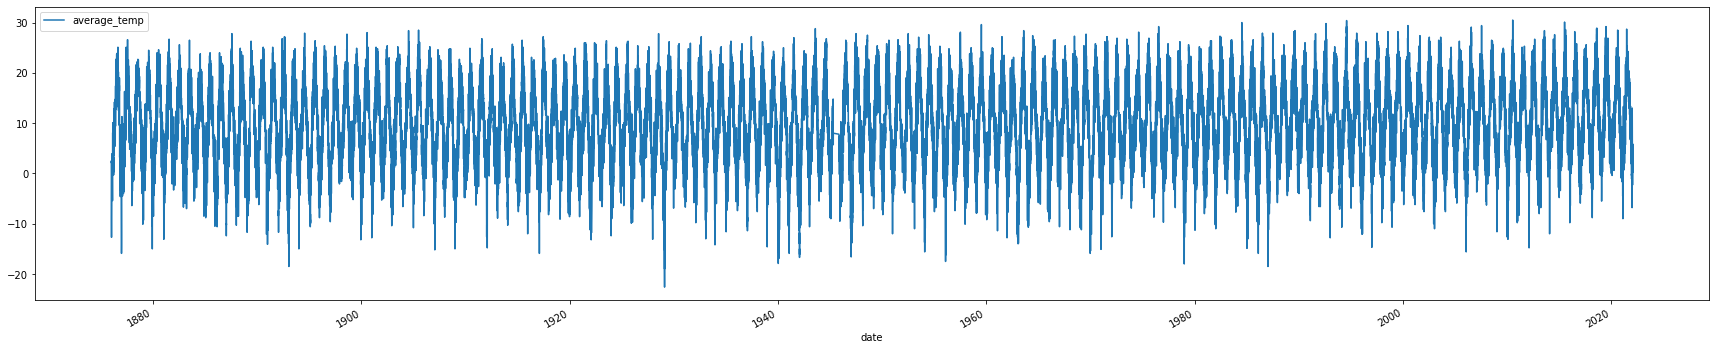

In [95]:
df.plot(figsize = (30, 6))

In [96]:
# we have to remove the trend and seasonal data and keep the remainder
# we can remove trend using linear regression model
# Create a new feature named timestep --> Use that feature as your X --> use "average_temp" as y --> Run a linear regression

In [97]:
df["timestep"] = range(len(df))
df.head()

,average_temp,timestep
date,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [98]:
X_trend = df[["timestep"]]
y = df["average_temp"]

In [99]:
### Let us define a linear regression model
m = LinearRegression()

In [100]:
### Fit the data
m.fit(X_trend, y)

LinearRegression()

In [101]:
### make predictions of trend
df["trend"] = m.predict(X_trend)

In [102]:
df.head(10)

,average_temp,timestep,trend
date,,,
1876-01-01,2.2,0,8.506620
1876-01-02,2.5,1,8.506653
1876-01-03,0.3,2,8.506686
1876-01-04,-5.8,3,8.506720
1876-01-05,-9.8,4,8.506753
1876-01-06,-7.7,5,8.506787
1876-01-07,-6.6,6,8.506820
1876-01-08,-8.9,7,8.506853
1876-01-09,-12.7,8,8.506887


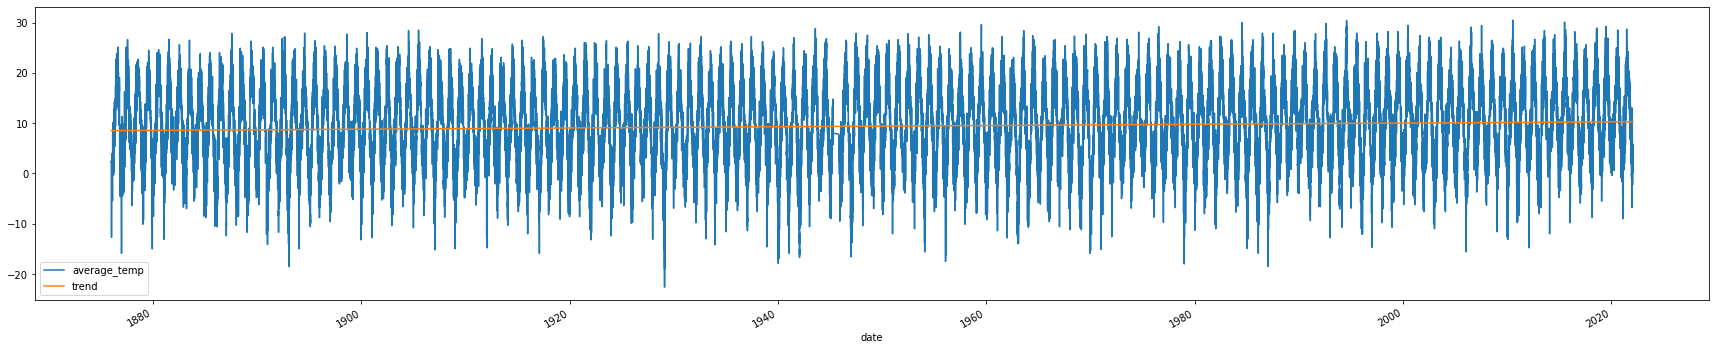

In [103]:
### Lets make a plot of temperature data and trend
df[["average_temp", "trend"]].plot(figsize = (30, 6));

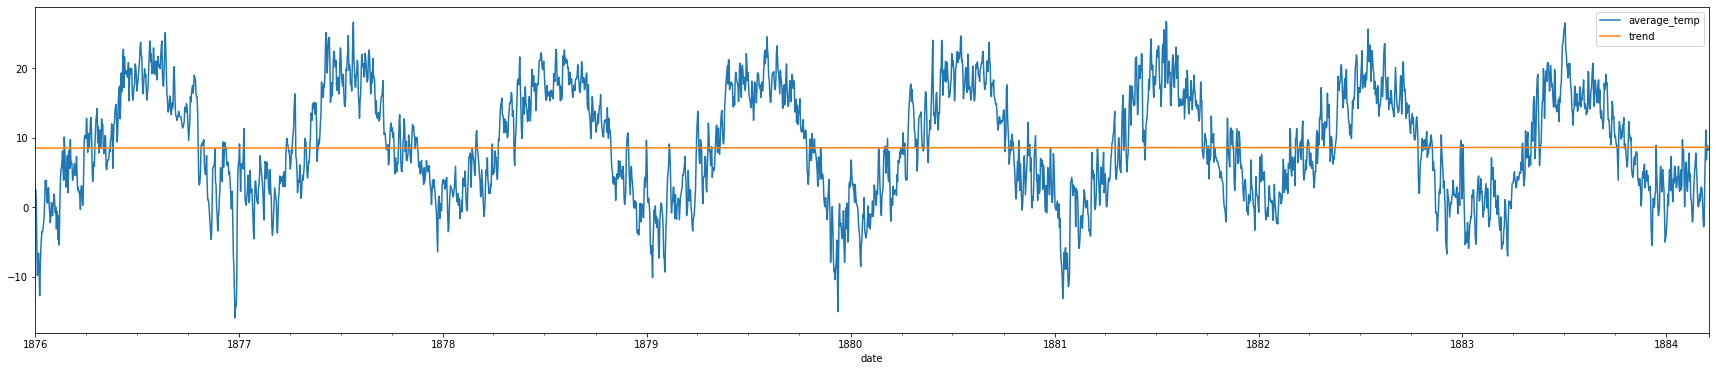

In [104]:
# let's zoom a bit to see what's going on..
df[["average_temp", "trend"]][0:3000].plot(figsize = (30, 6));

In [105]:
# Also we have seasonality and we need to model it, then we have to extract trend and seasonaliity to get to the remainder
# Once we have modeled the trend, the easiest way to model the seasonality is to create dummy features for each season.
# use the timestep feature and the seasonal dummies as X and se "average_temp" as y --> Run a linear regression
month_dummies = pd.get_dummies(df.index.month, prefix="month").set_index(df.index)

In [106]:
month_dummies

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
1876-01-01,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,1,0,0,0,0,0,0,0,0,0,0,0
2022-01-28,1,0,0,0,0,0,0,0,0,0,0,0
2022-01-29,1,0,0,0,0,0,0,0,0,0,0,0


In [107]:
df = df.join(month_dummies)
df.head()

,average_temp,timestep,trend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,
1876-01-01,2.2,0,8.506620,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,8.506653,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,8.506686,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,8.506720,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,8.506753,1,0,0,0,0,0,0,0,0,0,0,0


In [108]:
# Use the timestep feature and the seasonal dummies as X

X_seasonality = df.drop(["average_temp", "trend"], axis=1)
y = df["average_temp"]

In [109]:
X_seasonality

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1876-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,53157,1,0,0,0,0,0,0,0,0,0,0,0
2022-01-28,53158,1,0,0,0,0,0,0,0,0,0,0,0
2022-01-29,53159,1,0,0,0,0,0,0,0,0,0,0,0


In [110]:
y

date
1876-01-01    2.2
1876-01-02    2.5
1876-01-03    0.3
1876-01-04   -5.8
1876-01-05   -9.8
             ... 
2022-01-27    4.4
2022-01-28    4.9
2022-01-29    5.8
2022-01-30    5.8
2022-01-31    2.9
Name: average_temp, Length: 53162, dtype: float64

In [111]:
# Re-train the model using the new independent variable X_seasonality
m.fit(X_seasonality, y)

LinearRegression()

In [112]:
df["trend_seasonal"] = m.predict(X_seasonality)

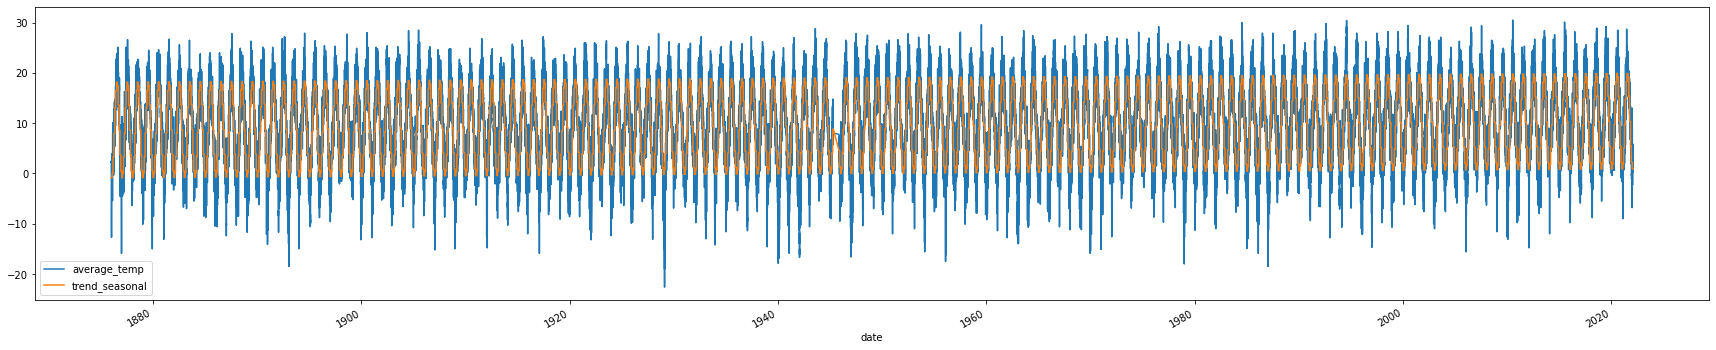

In [113]:
df[["average_temp", "trend_seasonal"]].plot(figsize = (30, 6));

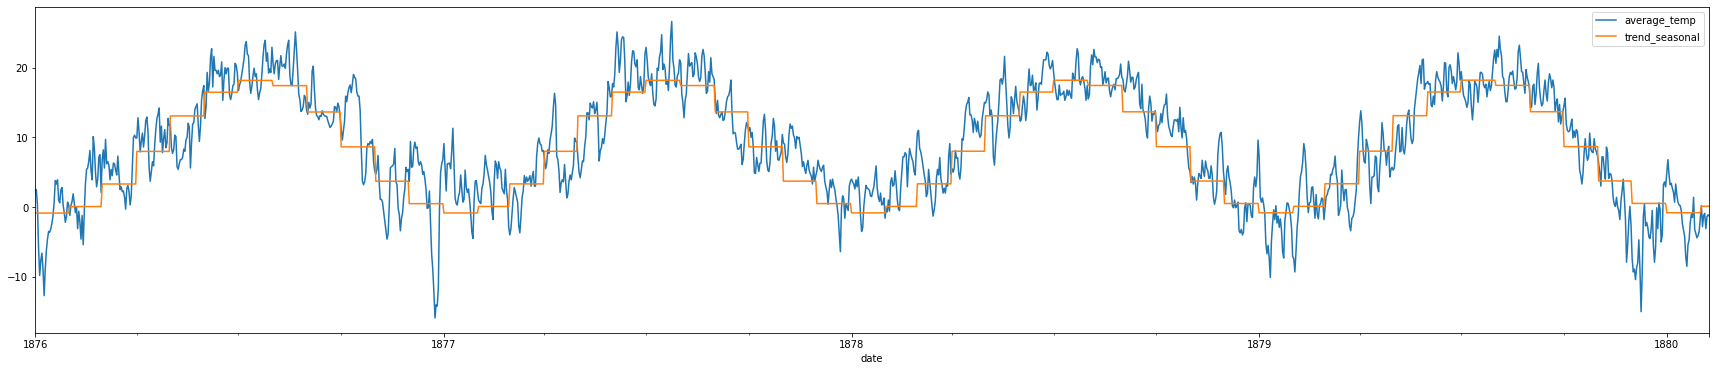

In [114]:
# Let's zoom a bit
df[["average_temp", "trend_seasonal"]][0:1500].plot(figsize = (30, 6));

In [115]:
# Obtain the remainder (after subtracting the trend and the seasonal components)
df["remainder"] = df["average_temp"] - df["trend_seasonal"]

In [116]:
df

,average_temp,timestep,trend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,8.506620,1,0,0,0,0,0,0,0,0,0,0,0,-0.863231,3.063231
1876-01-02,2.5,1,8.506653,1,0,0,0,0,0,0,0,0,0,0,0,-0.863197,3.363197
1876-01-03,0.3,2,8.506686,1,0,0,0,0,0,0,0,0,0,0,0,-0.863164,1.163164
1876-01-04,-5.8,3,8.506720,1,0,0,0,0,0,0,0,0,0,0,0,-0.863131,-4.936869
1876-01-05,-9.8,4,8.506753,1,0,0,0,0,0,0,0,0,0,0,0,-0.863098,-8.936902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,4.4,53157,10.280516,1,0,0,0,0,0,0,0,0,0,0,0,0.903051,3.496949
2022-01-28,4.9,53158,10.280549,1,0,0,0,0,0,0,0,0,0,0,0,0.903084,3.996916
2022-01-29,5.8,53159,10.280583,1,0,0,0,0,0,0,0,0,0,0,0,0.903118,4.896882


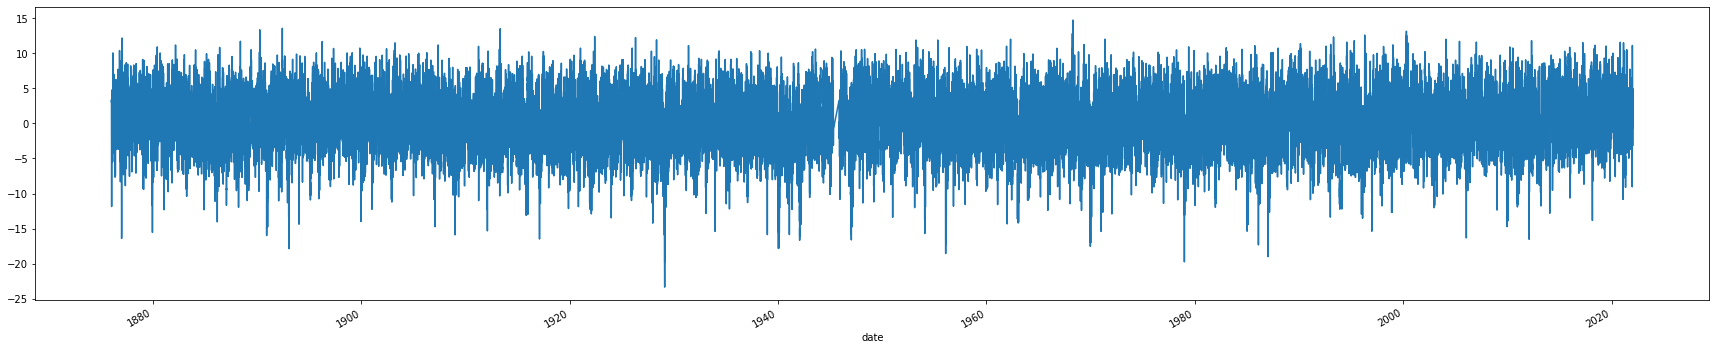

In [117]:
df["remainder"].plot(figsize = (30, 6));

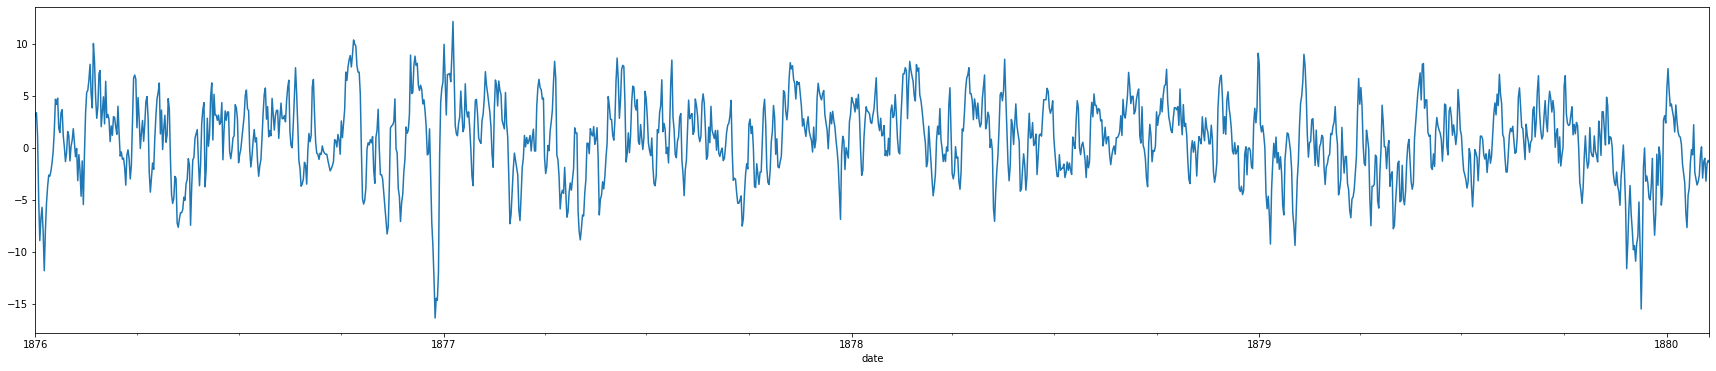

In [118]:
df["remainder"][0:1500].plot(figsize = (30, 6));

In [119]:
df

,average_temp,timestep,trend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,8.506620,1,0,0,0,0,0,0,0,0,0,0,0,-0.863231,3.063231
1876-01-02,2.5,1,8.506653,1,0,0,0,0,0,0,0,0,0,0,0,-0.863197,3.363197
1876-01-03,0.3,2,8.506686,1,0,0,0,0,0,0,0,0,0,0,0,-0.863164,1.163164
1876-01-04,-5.8,3,8.506720,1,0,0,0,0,0,0,0,0,0,0,0,-0.863131,-4.936869
1876-01-05,-9.8,4,8.506753,1,0,0,0,0,0,0,0,0,0,0,0,-0.863098,-8.936902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,4.4,53157,10.280516,1,0,0,0,0,0,0,0,0,0,0,0,0.903051,3.496949
2022-01-28,4.9,53158,10.280549,1,0,0,0,0,0,0,0,0,0,0,0,0.903084,3.996916
2022-01-29,5.8,53159,10.280583,1,0,0,0,0,0,0,0,0,0,0,0,0.903118,4.896882


In [120]:
### Stationarity - Statistical tests: 

# Note: Here we considered data as stationary 
# But typically for such conclusion, statistical tests are performed sich as:
    # 1. Augmented Dickey Fuller Test (ADF) and/or  
    # 2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS)





In [121]:
# Augmented Dickey Fuller Test (ADF)

# Hypothesis A : There is a unit root i.e. the time series is non stationary
# Hypothesis B : There is no unit root i.e. the time series is stationary

In [122]:
X = df['average_temp'].values
result = sm.tsa.stattools.adfuller(X)
print('ADF: %f' % result[0])
print('p-value: %.15f' % result[1])
print('usedlag: %f' % result[2])
print('nobs: %f' % result[3])
print('information criterion (AIC): %f' % result[5])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF: -20.418851
p-value: 0.000000000000000
usedlag: 58.000000
nobs: 53103.000000
information criterion (AIC): 238028.549755
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [123]:
# The p value  is less than 0.05, thus we reject the Hypothesis A. 
# ADF: -20.418851 < -3.430, thus we can reject the Hypothesis A with a confidence level of 99%. 
# Therefore, the series has no unit root and is stationary.

In [124]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test)

# Hypothesis AA : The process is trend stationary.
# Hypothesis BB : The series has a unit root (series is not stationary)

In [125]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [126]:
kpss_test(df['average_temp'].values)

Results of KPSS Test:
Test Statistic             0.355440
p-value                    0.096362
Lags Used                134.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


In [127]:
# The p value  is larger than 0.05, thus we fail to reject the Hypothesis AA.
#  conclude that the series is stationary , as we said before statistical tests

In [128]:
# Now, let's save the remainder data to a separate CSV file so that we can model it later

In [129]:
df["remainder"].to_csv("temperature_remainder.csv")

In [130]:
# we are going to use Autoregressive Integrated Moving Average (ARIMA) model for time series, 
# to do that, first we have to determine the model parameters like p, q, d
    # this can be done by looking at the graphs of  auto-correlation function (ACF) and partial auto-correlation function (PACF)
    # also it can be done with the help of AUTO_ARIMA


#let's first import some other modules that might be necessary
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

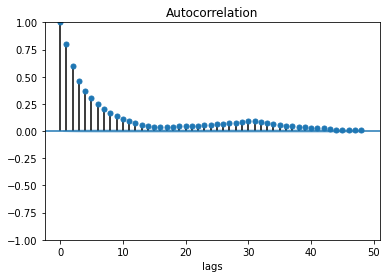

In [131]:
plot_acf(df['remainder'])
plt.xlabel('lags');

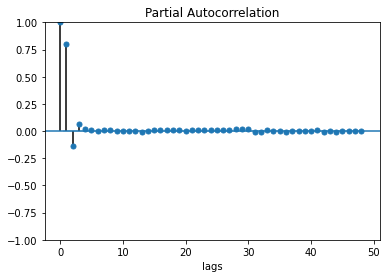

In [132]:
# Statsmodels provides a function called plot_pacf and plot_acf

plot_pacf(df['remainder'])
plt.xlabel('lags');

In [133]:
# what does these two graphs say?:
  # ACF-Plot shows an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag? --> data is best modelled by an AR(p) process --> P is the last meaningful lag in the PACF-Plot
  # ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay? --> data is best modelled by an MA(q) process --> q is the last meaningful lag in the ACF-Plot
  # both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay? --> data is best modelled by an ARIMA(p,d,q) process --> p and q cannot be inferred from the plots. Usually we would use an iterative approach and try different combinations to find the best model.

In [134]:
selected_order = ar_select_order(df['remainder'], maxlag = 12);

In [135]:
selected_order.ar_lags

[1, 2, 3, 4]

In [136]:
# It seems we need to include 4 lags. However, only for now, we just include one lag which has the highest correlation with the remainder.

In [137]:
df['lag1'] = df['remainder'].shift(1)
df.head()


,average_temp,timestep,trend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,8.506620,1,0,0,0,0,0,0,0,0,0,0,0,-0.863231,3.063231,NaN
1876-01-02,2.5,1,8.506653,1,0,0,0,0,0,0,0,0,0,0,0,-0.863197,3.363197,3.063231
1876-01-03,0.3,2,8.506686,1,0,0,0,0,0,0,0,0,0,0,0,-0.863164,1.163164,3.363197
1876-01-04,-5.8,3,8.506720,1,0,0,0,0,0,0,0,0,0,0,0,-0.863131,-4.936869,1.163164
1876-01-05,-9.8,4,8.506753,1,0,0,0,0,0,0,0,0,0,0,0,-0.863098,-8.936902,-4.936869


In [138]:
# Splitting the data into the train and test amples

df.dropna(inplace = True)

X = df.drop(['average_temp', 'remainder'], axis = 1)
y = df['average_temp']

In [139]:
test_size = 0.2
train_size = 1.0 - test_size
nsplit = int(train_size * len(X))

X_train = X.iloc[:nsplit, :]
y_train = y[:nsplit]

X_test = X.iloc[nsplit:]
y_test = y[nsplit:]

In [140]:
# Calculating the cross-validation score on the train dataset

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [141]:
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_train, y_train)

In [142]:
lr = LinearRegression()

In [143]:
result = cross_val_score(estimator=lr, X=X_train, y=y_train, cv=time_series_split, scoring = 'r2')

In [144]:
print(f'Train Score = {round(np.mean(result), 3)} +/- {round(np.std(result), 3)}')

Train Score = 0.908 +/- 0.005


In [145]:
# Fitting the LinearRegression model on the train data

lr.fit(X_train, y_train)

LinearRegression()

In [147]:
# predicting the values and Calculating the score on the test data

y_pred = lr.predict(X_test)


In [149]:

from sklearn.metrics import r2_score

test_score = r2_score(y_test, y_pred)
print(f'Test Score = {round(np.mean(test_score), 3)} +/- {round(np.std(test_score), 3)}')

Test Score = 0.915 +/- 0.0


In [150]:
#  Plotting the predictions on the test data

In [151]:
dfx = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}, index = X_test.index)

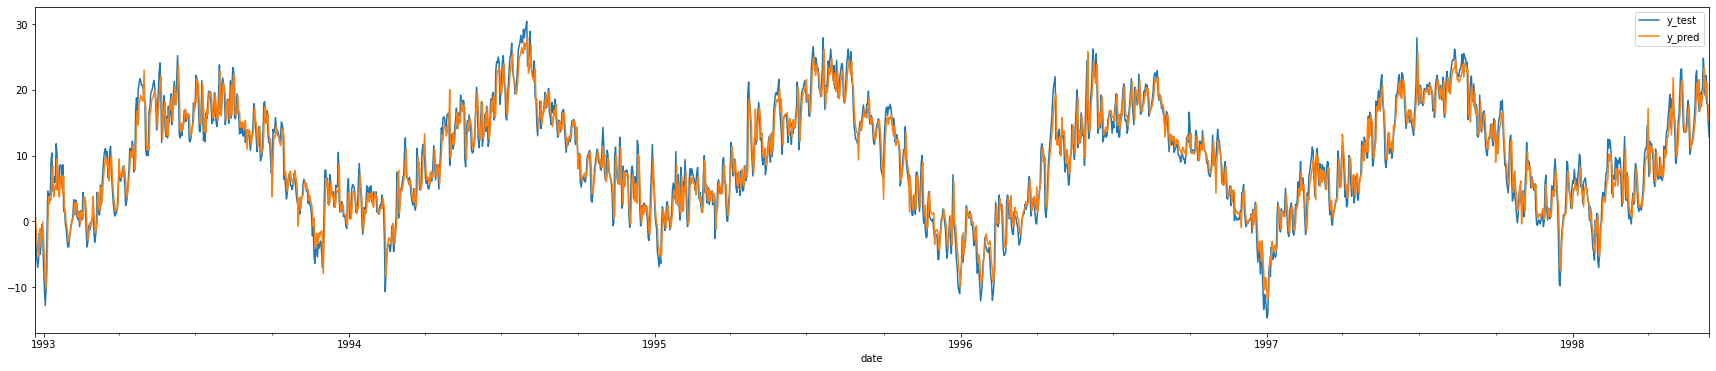

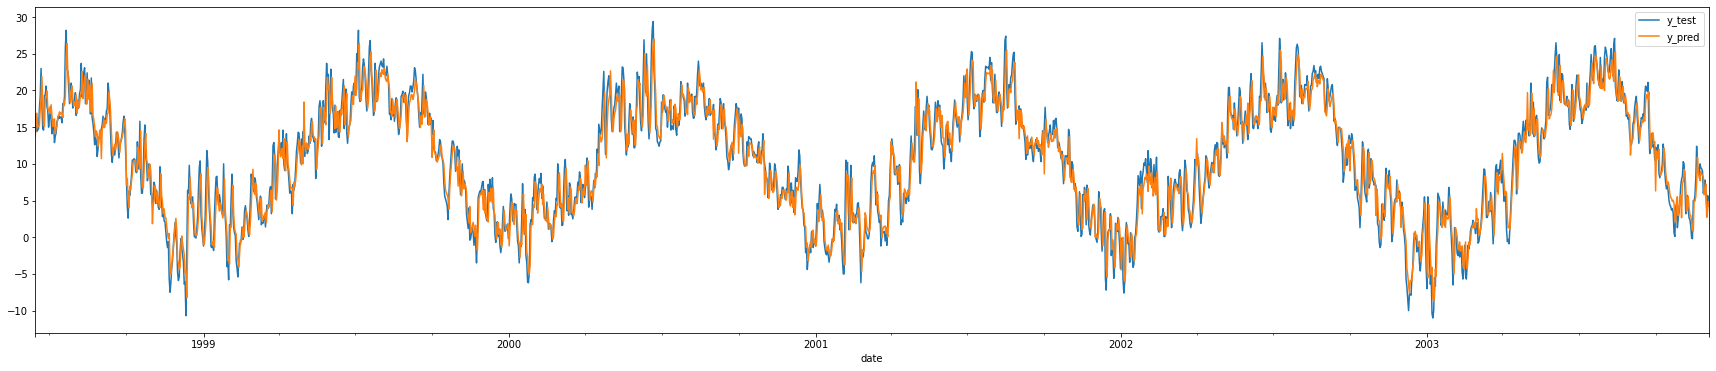

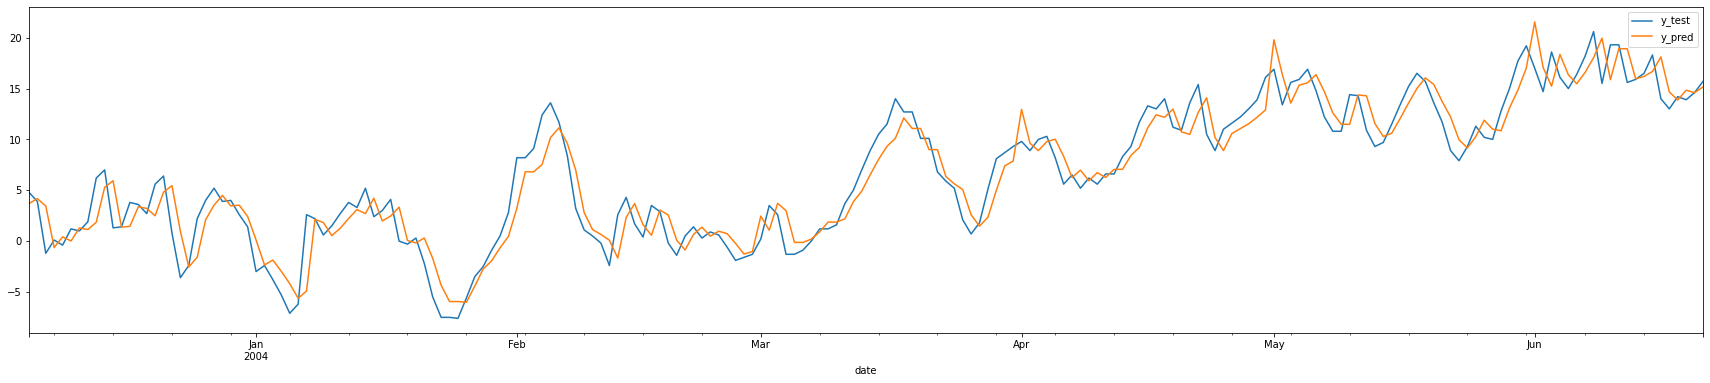

In [153]:
dfx[:2000].plot(figsize = (30, 6))
dfx[2000:4000].plot(figsize = (30, 6))
dfx[4000:4200].plot(figsize = (30, 6));
